# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=45,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_14-39-31/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4822 | MulticlassF1Score=0.2082
Batch-30 : CrossEntropyLoss=2.4676 | MulticlassF1Score=0.2466
Batch-45 : CrossEntropyLoss=2.4584 | MulticlassF1Score=0.3038
Batch-60 : CrossEntropyLoss=2.4207 | MulticlassF1Score=0.3435
Batch-75 : CrossEntropyLoss=2.3880 | MulticlassF1Score=0.3794
Batch-90 : CrossEntropyLoss=2.3649 | MulticlassF1Score=0.4208
Batch-105: CrossEntropyLoss=2.3517 | MulticlassF1Score=0.4543
Batch-120: CrossEntropyLoss=2.3373 | MulticlassF1Score=0.4797
Batch-135: CrossEntropyLoss=2.3503 | MulticlassF1Score=0.5011
Batch-150: CrossEntropyLoss=2.3577 | MulticlassF1Score=0.5182
Batch-165: CrossEntropyLoss=2.3331 | MulticlassF1Score=0.5320
Batch-180: CrossEntropyLoss=2.3471 | MulticlassF1Score=0.5461
Batch-195: CrossEntropyLoss=2.3334 | MulticlassF1Score=0.5587
Batch-210: CrossEntropyLoss=2.3408 | MulticlassF1Score=0.5692
Batch-225: CrossEntropyLoss=2.3315 | MulticlassF1Score=0.5807
Batch-226: CrossEntropyLoss=2.3258 | MulticlassF1Score=0.5812

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3301 | MulticlassF1Score=0.7564
Batch-30 : CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7609
Batch-45 : CrossEntropyLoss=2.3188 | MulticlassF1Score=0.7622
Batch-60 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.7627
Batch-63 : CrossEntropyLoss=2.3268 | MulticlassF1Score=0.7621

Training   : Mean CrossEntropyLoss = 2.3900 | Mean MulticlassF1Score = 0.4300
Validation : Mean CrossEntropyLoss = 2.3239 | Mean MulticlassF1Score = 0.7605

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3210 | MulticlassF1Score=0.7705
Batch-30 : CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7827
Batch-45 : CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7836
Batch-60 : CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7839
Batch-75 : CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7835
Batch-90 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7842
Batch-105: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7852
Batch-120: CrossEntropyLoss=2.3224 | MulticlassF1Score=0.7858
Batch-135: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.7864
Batch-150: CrossEntropyLoss=2.3187 | MulticlassF1Score=0.7866
Batch-165: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.7863
Batch-180: CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7864
Batch-195: CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7866
Batch-210: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7875
Batch-225: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7875
Batch-226: CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7876

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.7930
Batch-30 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7929
Batch-45 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7924
Batch-60 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7929
Batch-63 : CrossEntropyLoss=2.3268 | MulticlassF1Score=0.7918

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3145 | Mean MulticlassF1Score = 0.7838
Validation : Mean CrossEntropyLoss = 2.3126 | Mean MulticlassF1Score = 0.7929

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7955
Batch-30 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.7961
Batch-45 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7982
Batch-60 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8025
Batch-75 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8057
Batch-90 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8068
Batch-105: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8080
Batch-120: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8090
Batch-135: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8094
Batch-150: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8088
Batch-165: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8087
Batch-180: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8089
Batch-195: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8095
Batch-210: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8103
Batch-225: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8107
Batch-226: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8107

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8122
Batch-30 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8164
Batch-45 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8145
Batch-60 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8129
Batch-63 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3068 | Mean MulticlassF1Score = 0.8056
Validation : Mean CrossEntropyLoss = 2.3056 | Mean MulticlassF1Score = 0.8145

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8143
Batch-30 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8149
Batch-45 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8143
Batch-60 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8162
Batch-75 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8154
Batch-90 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8165
Batch-105: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8168
Batch-120: CrossEntropyLoss=2.3149 | MulticlassF1Score=0.8176
Batch-135: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8177
Batch-150: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8171
Batch-165: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8168
Batch-180: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8177
Batch-195: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8188
Batch-210: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8198
Batch-225: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8205
Batch-226: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8206

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8306
Batch-30 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8267
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8276
Batch-60 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8272
Batch-63 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3035 | Mean MulticlassF1Score = 0.8171
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8286

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8295
Batch-30 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8332
Batch-45 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8327
Batch-60 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8325
Batch-75 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8306
Batch-90 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8299
Batch-105: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8302
Batch-120: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8301
Batch-135: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8302
Batch-150: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8298
Batch-165: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8298
Batch-180: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8300
Batch-195: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8300
Batch-210: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8301
Batch-225: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8306
Batch-226: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8306

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8271
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8280
Batch-45 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8281
Batch-60 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8279
Batch-63 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8309
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8292

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8322
Batch-30 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8326
Batch-45 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8332
Batch-60 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8337
Batch-75 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8322
Batch-90 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8309
Batch-105: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8311
Batch-120: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8314
Batch-135: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8315
Batch-150: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8314
Batch-165: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8318
Batch-180: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8322
Batch-195: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8318
Batch-210: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8326
Batch-225: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8327
Batch-226: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8327

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8392
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8309
Batch-45 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8298
Batch-60 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8299
Batch-63 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8303

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2996 | Mean MulticlassF1Score = 0.8319
Validation : Mean CrossEntropyLoss = 2.3003 | Mean MulticlassF1Score = 0.8341

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8366
Batch-30 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8343
Batch-45 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8345
Batch-60 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8345
Batch-75 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8338
Batch-90 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8333
Batch-105: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8325
Batch-120: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8325
Batch-135: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8331
Batch-150: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8330
Batch-165: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8337
Batch-180: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8346
Batch-195: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8360
Batch-210: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8370
Batch-225: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8377
Batch-226: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8377

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8396
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8426
Batch-45 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8423
Batch-60 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8424
Batch-63 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8422

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2983 | Mean MulticlassF1Score = 0.8346
Validation : Mean CrossEntropyLoss = 2.2972 | Mean MulticlassF1Score = 0.8414

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8529
Batch-30 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8533
Batch-45 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8515
Batch-60 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8513
Batch-75 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8513
Batch-90 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8513
Batch-105: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8517
Batch-120: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8514
Batch-135: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8513
Batch-150: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8517
Batch-165: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8514
Batch-180: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8510
Batch-195: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8509
Batch-210: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8507
Batch-225: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8503
Batch-226: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8504

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8471
Batch-30 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8454
Batch-45 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8469
Batch-60 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8469
Batch-63 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2943 | Mean MulticlassF1Score = 0.8515
Validation : Mean CrossEntropyLoss = 2.2952 | Mean MulticlassF1Score = 0.8466

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8511
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8520
Batch-45 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8534
Batch-60 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8523
Batch-75 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8524
Batch-90 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8518
Batch-105: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8518
Batch-120: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8522
Batch-135: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8522
Batch-150: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8524
Batch-165: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8523
Batch-180: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8523
Batch-195: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8529
Batch-210: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8525
Batch-225: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8522
Batch-226: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8522

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8522
Batch-30 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8495
Batch-45 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8483
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8472
Batch-63 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2935 | Mean MulticlassF1Score = 0.8527
Validation : Mean CrossEntropyLoss = 2.2950 | Mean MulticlassF1Score = 0.8471

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8536
Batch-30 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8488
Batch-45 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8499
Batch-60 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8516
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8533
Batch-90 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8535
Batch-105: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8534
Batch-120: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8534
Batch-135: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8541
Batch-150: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8548
Batch-165: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8552
Batch-180: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8556
Batch-195: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8552
Batch-210: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8552
Batch-225: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8555
Batch-226: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8556

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8491
Batch-30 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8519
Batch-45 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8484
Batch-60 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8484
Batch-63 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2924 | Mean MulticlassF1Score = 0.8535
Validation : Mean CrossEntropyLoss = 2.2944 | Mean MulticlassF1Score = 0.8499

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8659
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8641
Batch-45 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8607
Batch-60 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8595
Batch-75 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8595
Batch-90 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8588
Batch-105: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8590
Batch-120: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8596
Batch-135: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8597
Batch-150: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8593
Batch-165: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8588
Batch-180: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8590
Batch-195: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8583
Batch-210: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8576
Batch-225: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8574
Batch-226: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8573

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8536
Batch-30 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8504
Batch-45 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8483
Batch-60 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8497
Batch-63 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8496

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2918 | Mean MulticlassF1Score = 0.8602
Validation : Mean CrossEntropyLoss = 2.2942 | Mean MulticlassF1Score = 0.8513

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8613
Batch-30 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8585
Batch-45 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8613
Batch-60 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8617
Batch-75 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8614
Batch-90 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8600
Batch-105: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8600
Batch-120: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8598
Batch-135: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8594
Batch-150: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8594
Batch-165: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8598
Batch-180: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8593
Batch-195: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8591
Batch-210: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8588
Batch-225: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8588
Batch-226: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8588

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8488
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8506
Batch-45 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8496
Batch-60 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8496
Batch-63 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8501

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2914 | Mean MulticlassF1Score = 0.8600
Validation : Mean CrossEntropyLoss = 2.2940 | Mean MulticlassF1Score = 0.8501

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8565
Batch-30 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8604
Batch-45 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8625
Batch-60 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8611
Batch-75 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8616
Batch-90 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8611
Batch-105: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8613
Batch-120: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8606
Batch-135: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8604
Batch-150: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8596
Batch-165: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8598
Batch-180: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8597
Batch-195: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8609
Batch-210: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8628
Batch-225: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8641
Batch-226: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8683
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8720
Batch-45 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8743
Batch-60 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8736
Batch-63 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8738

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2897 | Mean MulticlassF1Score = 0.8606
Validation : Mean CrossEntropyLoss = 2.2869 | Mean MulticlassF1Score = 0.8719

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8904
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8882
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8872
Batch-60 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8868
Batch-75 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8868
Batch-90 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8869
Batch-105: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8869
Batch-120: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8870
Batch-135: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8869
Batch-150: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8870
Batch-165: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8873
Batch-180: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8872
Batch-195: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8872
Batch-210: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8873
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8877
Batch-226: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8877

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8797
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8796
Batch-45 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8779
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8781
Batch-63 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8783

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8874
Validation : Mean CrossEntropyLoss = 2.2853 | Mean MulticlassF1Score = 0.8794

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8907
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8914
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8924
Batch-75 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8923
Batch-90 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8925
Batch-105: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8924
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8918
Batch-135: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8910
Batch-150: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8908
Batch-165: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8910
Batch-180: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8912
Batch-195: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8910
Batch-210: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8906
Batch-225: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8908
Batch-226: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8908

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8807
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8783
Batch-45 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8781
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8792
Batch-63 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8796

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8914
Validation : Mean CrossEntropyLoss = 2.2850 | Mean MulticlassF1Score = 0.8788

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8967
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8965
Batch-45 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8941
Batch-60 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8936
Batch-75 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8933
Batch-90 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8934
Batch-105: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8933
Batch-120: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8929
Batch-135: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8926
Batch-150: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8928
Batch-165: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8927
Batch-180: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8927
Batch-195: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8928
Batch-210: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8930
Batch-225: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8932
Batch-226: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8932

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8835
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8855
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8835
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8821
Batch-63 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8824

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8934
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8842

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8928
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.8953
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8998
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9019
Batch-75 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9035
Batch-90 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9042
Batch-105: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9042
Batch-120: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9045
Batch-135: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9038
Batch-150: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9036
Batch-165: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9042
Batch-180: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9041
Batch-195: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9039
Batch-210: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9038
Batch-225: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9043
Batch-226: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9042

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8980
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8925
Batch-60 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8921
Batch-63 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8917

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2774 | Mean MulticlassF1Score = 0.9019
Validation : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8940

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9106
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9085
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9076
Batch-60 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.9086
Batch-75 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9086
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9099
Batch-105: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9096
Batch-120: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9096
Batch-135: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9091
Batch-150: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9090
Batch-165: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9086
Batch-180: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9084
Batch-195: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9082
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9081
Batch-225: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9076
Batch-226: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9077

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8942
Batch-30 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8931
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8917
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8919
Batch-63 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8917

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9090
Validation : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8933

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9049
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9082
Batch-45 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9086
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9082
Batch-75 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9090
Batch-90 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9086
Batch-105: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9080
Batch-120: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9084
Batch-135: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9089
Batch-150: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9087
Batch-165: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9087
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9088
Batch-195: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9087
Batch-210: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9090
Batch-225: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9090
Batch-226: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9090

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8954
Batch-30 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8921
Batch-45 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8934
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8923
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8926

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9086
Validation : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8934

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9101
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9111
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9173
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9203
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9242
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9261
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9274
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9285
Batch-135: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9291
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9299
Batch-165: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9310
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9311
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9312
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9315
Batch-225: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9317
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9317

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9214

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9246
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9222

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9388
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9382
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9388
Batch-75 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9387
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9388
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9388
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9385
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9386
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9391
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9392
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9390
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9387
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9388

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9200
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9218
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9223

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9224

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9394
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9394
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9398
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9402
Batch-120: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9401
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9402
Batch-150: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9403
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9399
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9399
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9399
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9400
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9398
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9398

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9214
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9217
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9395
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9225

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9391
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9403
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9405
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9410
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9409
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9410
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9407
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9405
Batch-150: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9409
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9409
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9406
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9406
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9406

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9200
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9408
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9198

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9419
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9421
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9411
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9414
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9413
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9409
Batch-210: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9407
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9409
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9223
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9207
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9418
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9213

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9413
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9417
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9410
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9412
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9409
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9406
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9405
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9417
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9418
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9418
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9417
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9414
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9414
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9243

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9394
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9409
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9410
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9411
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9415
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9416
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9418
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9417
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9418
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9418

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9224

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9413
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9412
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9423
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9419
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9423
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9422
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9420
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9421
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9232
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9227
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9232

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9223

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9424
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9426
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9426
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9425
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9290
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9434
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9252

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9432
Batch-75 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9439
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9440
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9427
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9195
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9437
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9211

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9428
Batch-75 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9431
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9426
Batch-135: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9422
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9429
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9430
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9428
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9429
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9301
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9237
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9428
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9262

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9434
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9434
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9435
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9227

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9443
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9441
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9165
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9200
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9437
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9195

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9437
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9439
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9438
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9438
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9438
Batch-180: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9440
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9439
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9434
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9234

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9473
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9464
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9462
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9450
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9444
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9231
Batch-63 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9239

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9450
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9451
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9449
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9449
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9451
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9451
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9449
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9235

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9453
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9234

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9468
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9449
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9451
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9223

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9454
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9450
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9451
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9450
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9453
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9453
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9213
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9218
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9235
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9208

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9460
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9456
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9457
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9452
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9228

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9228
Patience = 1/50❗

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9466
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9480
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9496
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9507
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9517
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9524
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9530
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9530

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9429
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9427

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2621 | Mean MulticlassF1Score = 0.9471
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9434

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9645
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9640
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9643
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9640
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9639
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9641
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9643
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9643
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9643

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9433
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9434

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9650
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9441

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9659
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9673
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9664
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9662
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9660
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9658
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9430
Batch-63 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9434

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9428

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9656
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9658
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9658
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9656
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9657
Batch-195: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9659
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9659
Batch-225: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9659
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9660

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9424
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9435
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9436

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9656
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9428

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9669
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9663
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9663

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9437

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9441

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9664
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9450
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9427

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9689
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9672
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9670
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9433
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9436

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9428

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9650
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9670
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9667
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9439

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9666
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9427

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9661
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9660
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9668
Batch-75 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9438
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9439

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9430

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9673
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9677
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9673
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9454
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9446

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9439

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9659
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9662
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9665
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9669
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9668
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9668
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9432
Batch-63 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9436

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9665
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9445
Patience = 2/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9682
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2495 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9676
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9467

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2570
Best CrossEntropyLoss training    : 2.2638
Best MulticlassF1Score validation : 0.9676
Best MulticlassF1Score validation : 0.9467
Training duration                 : 2.2799 minutes.
Training date                     : 2022-10-19 10:28:29.321948+08:00


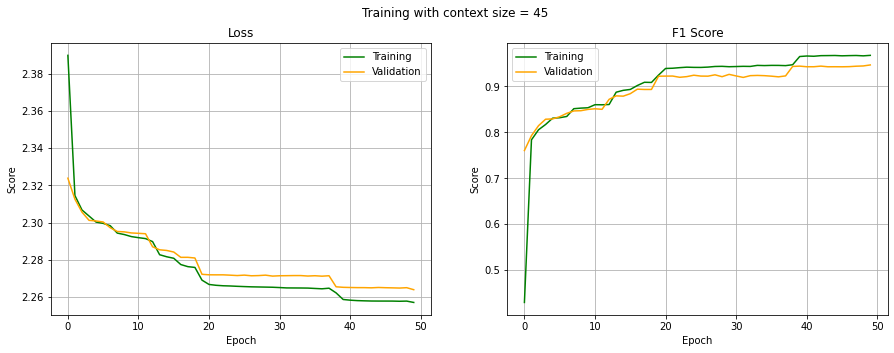

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9706, device='cuda:0'),
 tensor(0.9472, device='cuda:0'),
 tensor(0.9489, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9706, device='cuda:0'),
 tensor(0.9472, device='cuda:0'),
 tensor(0.9489, device='cuda:0'))

## Heatmap

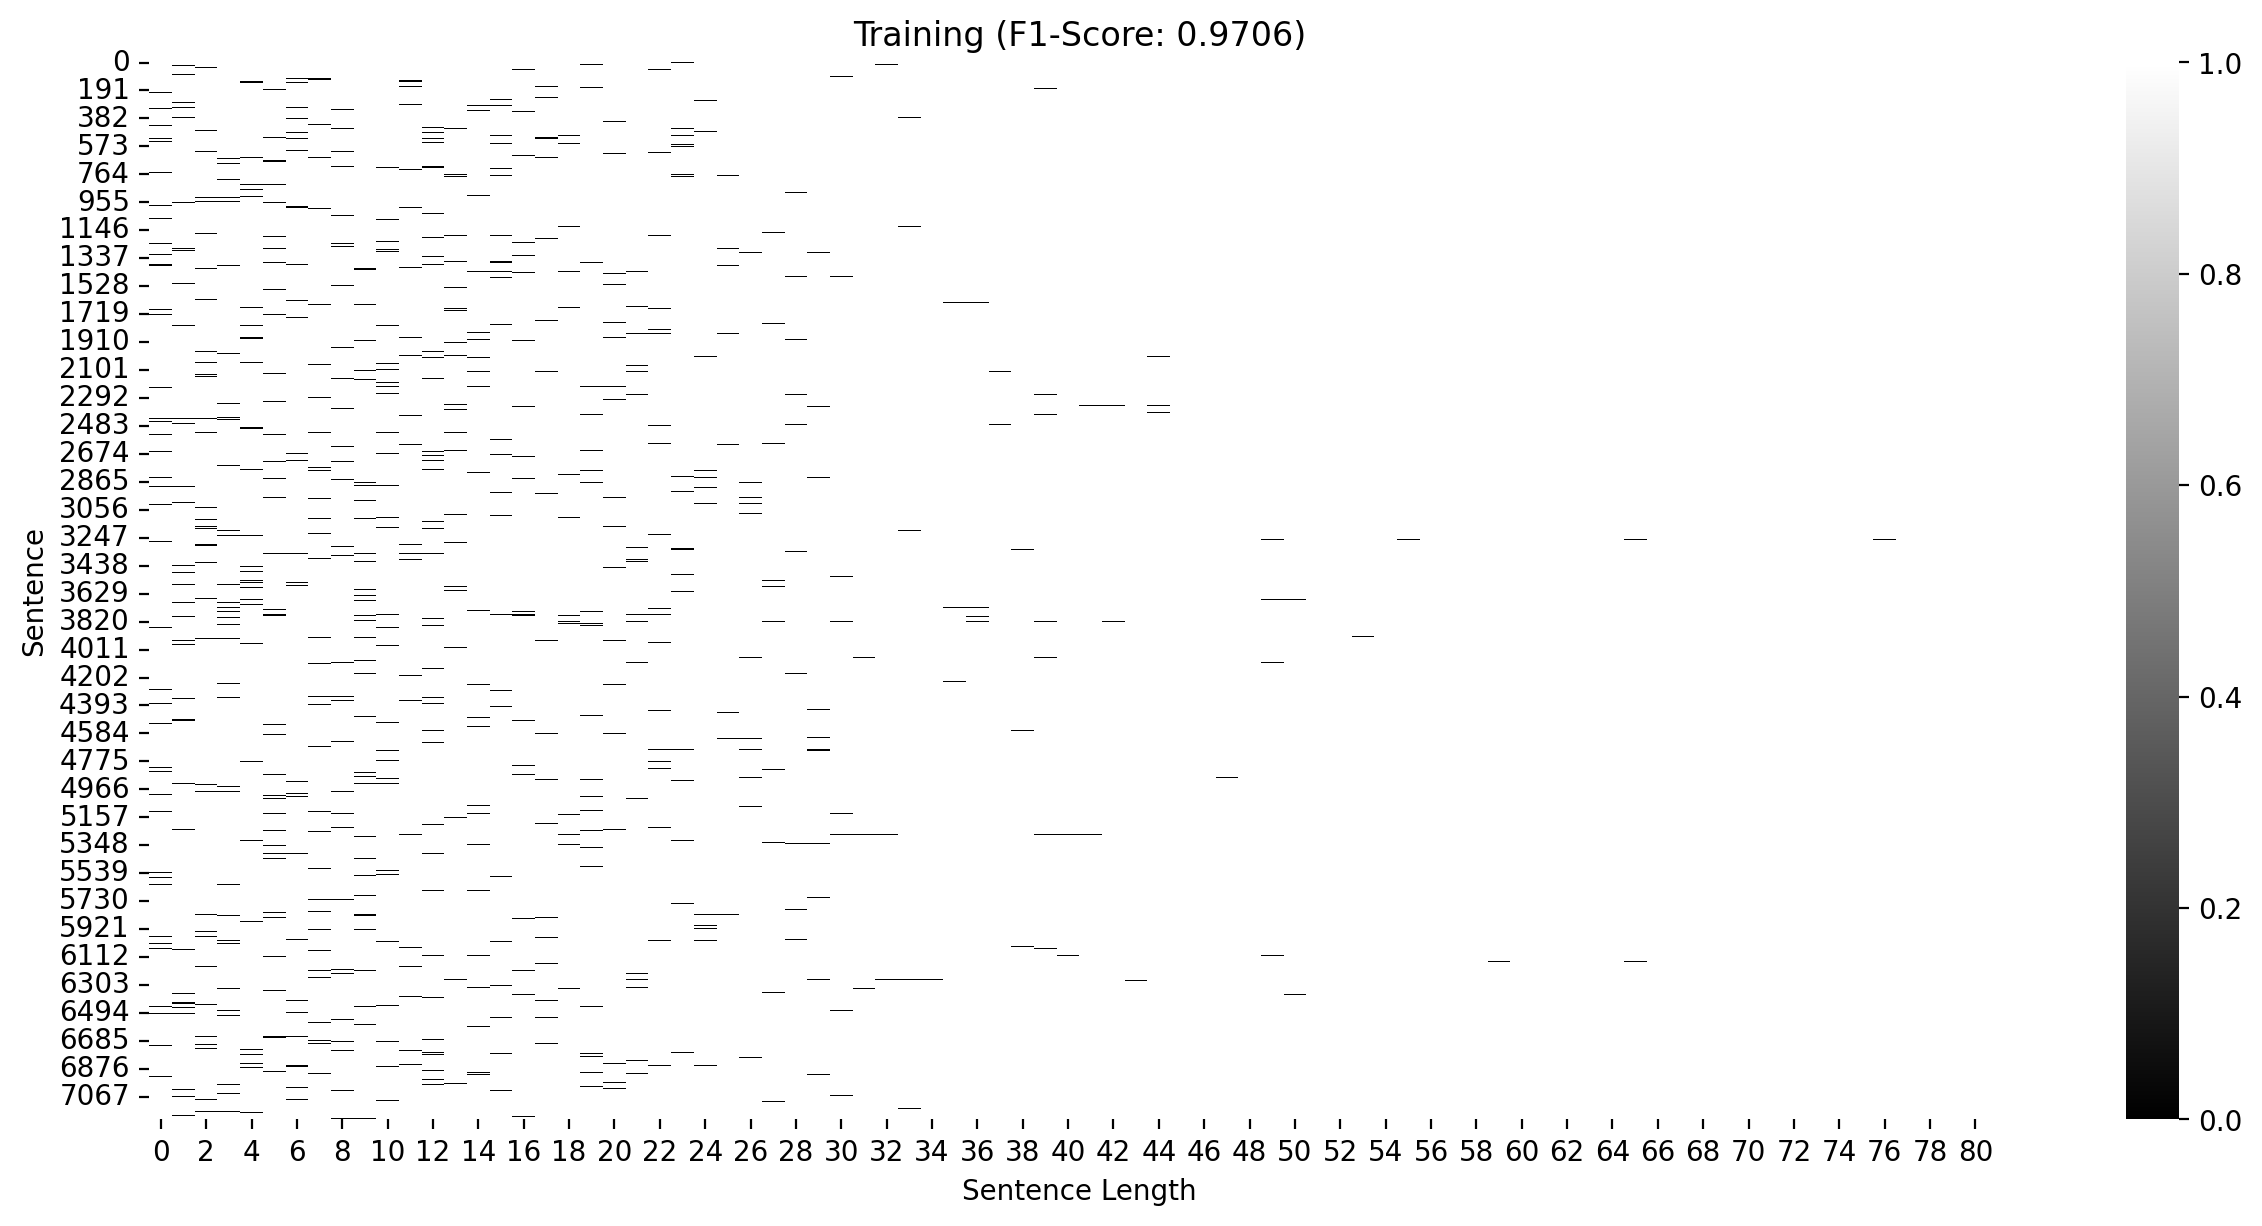

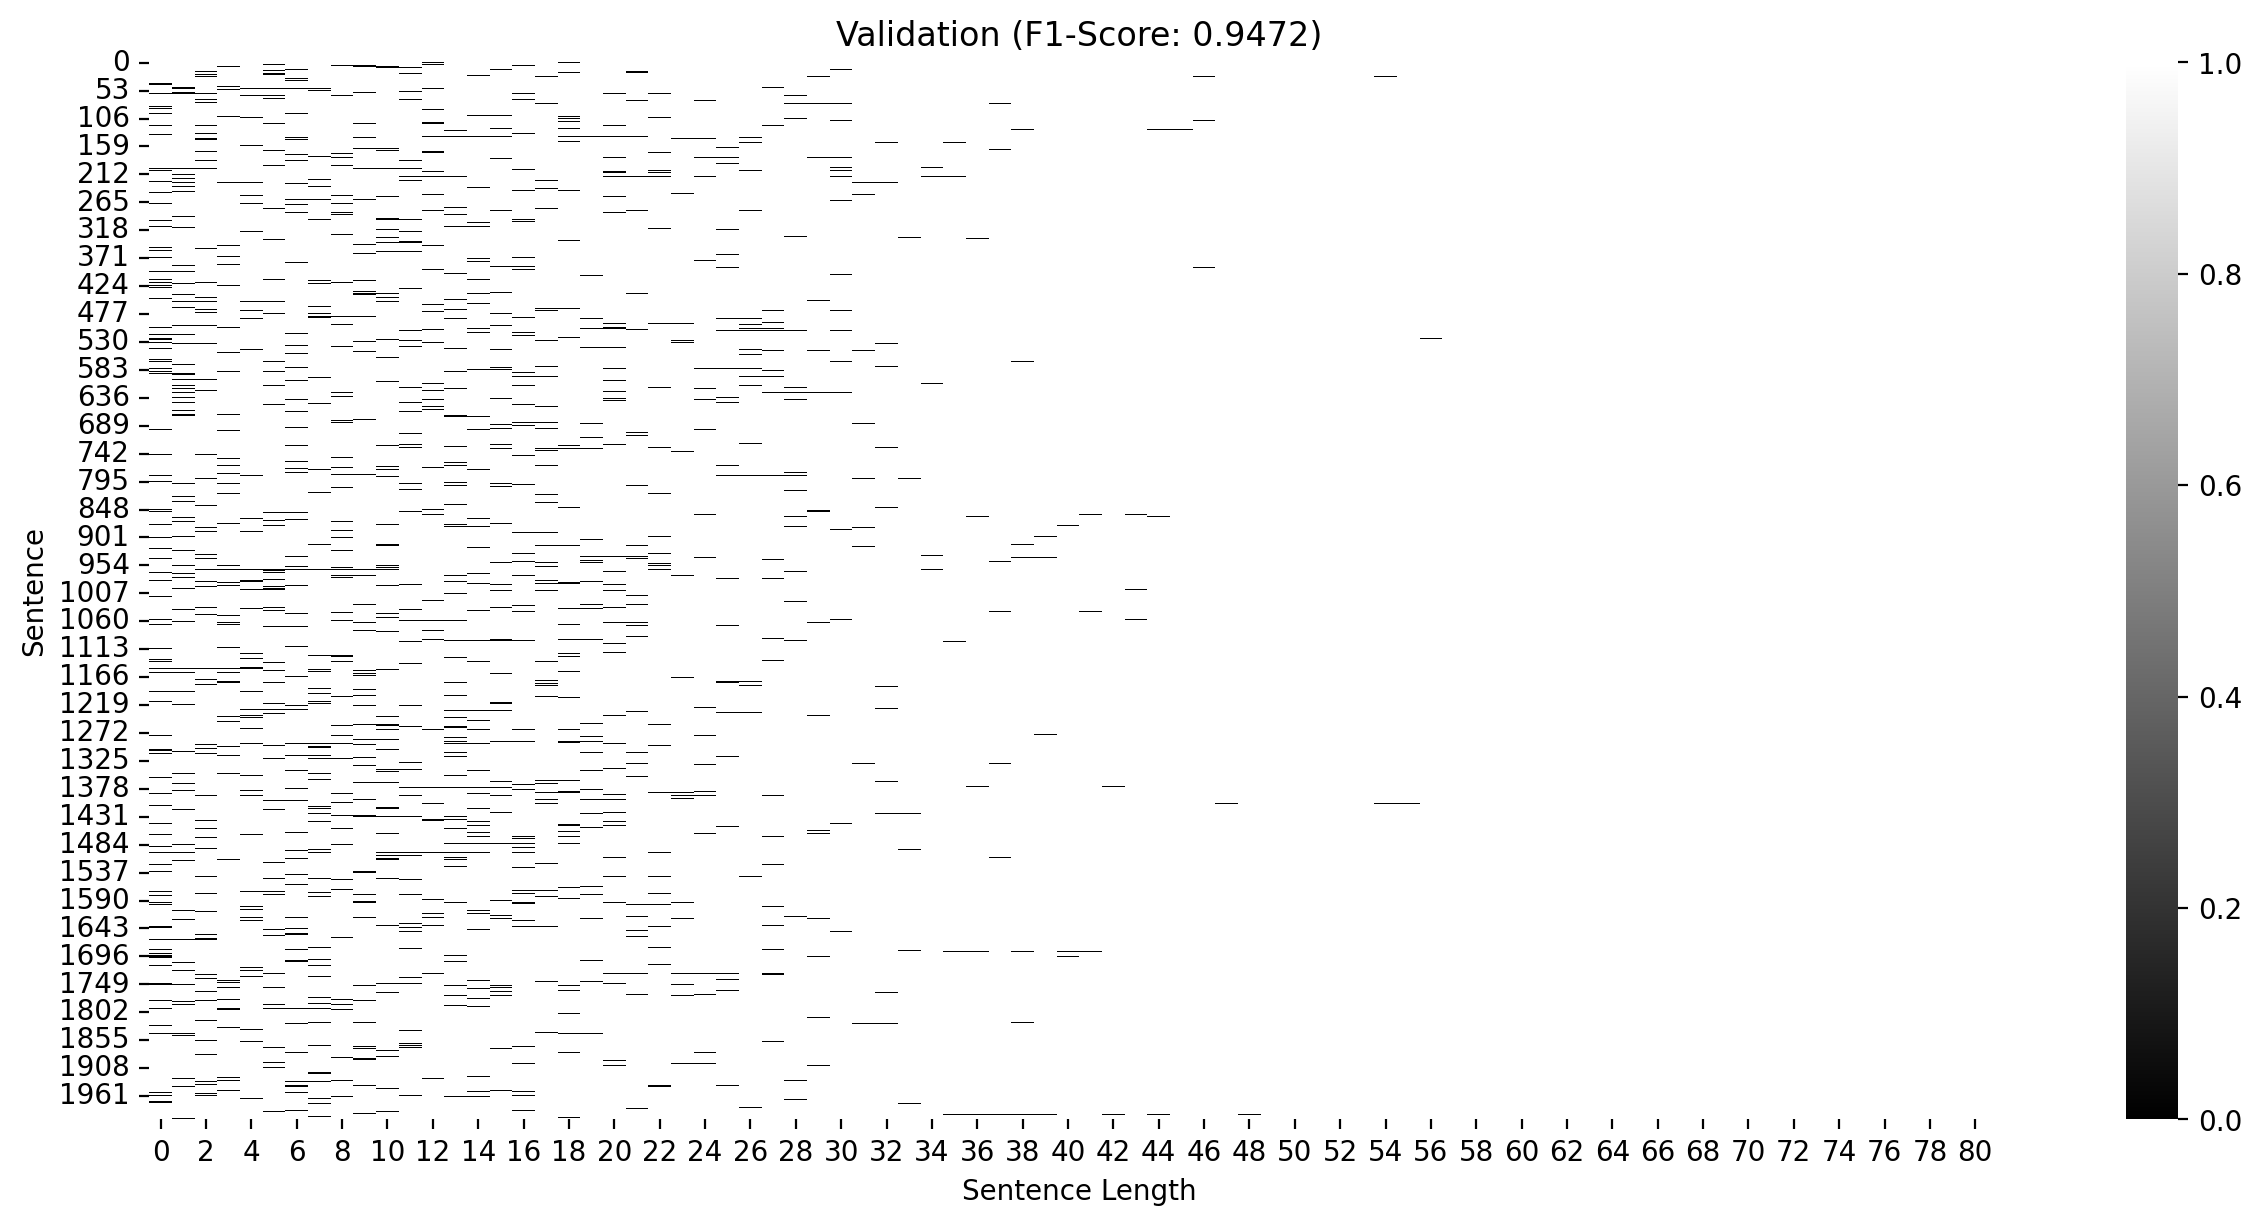

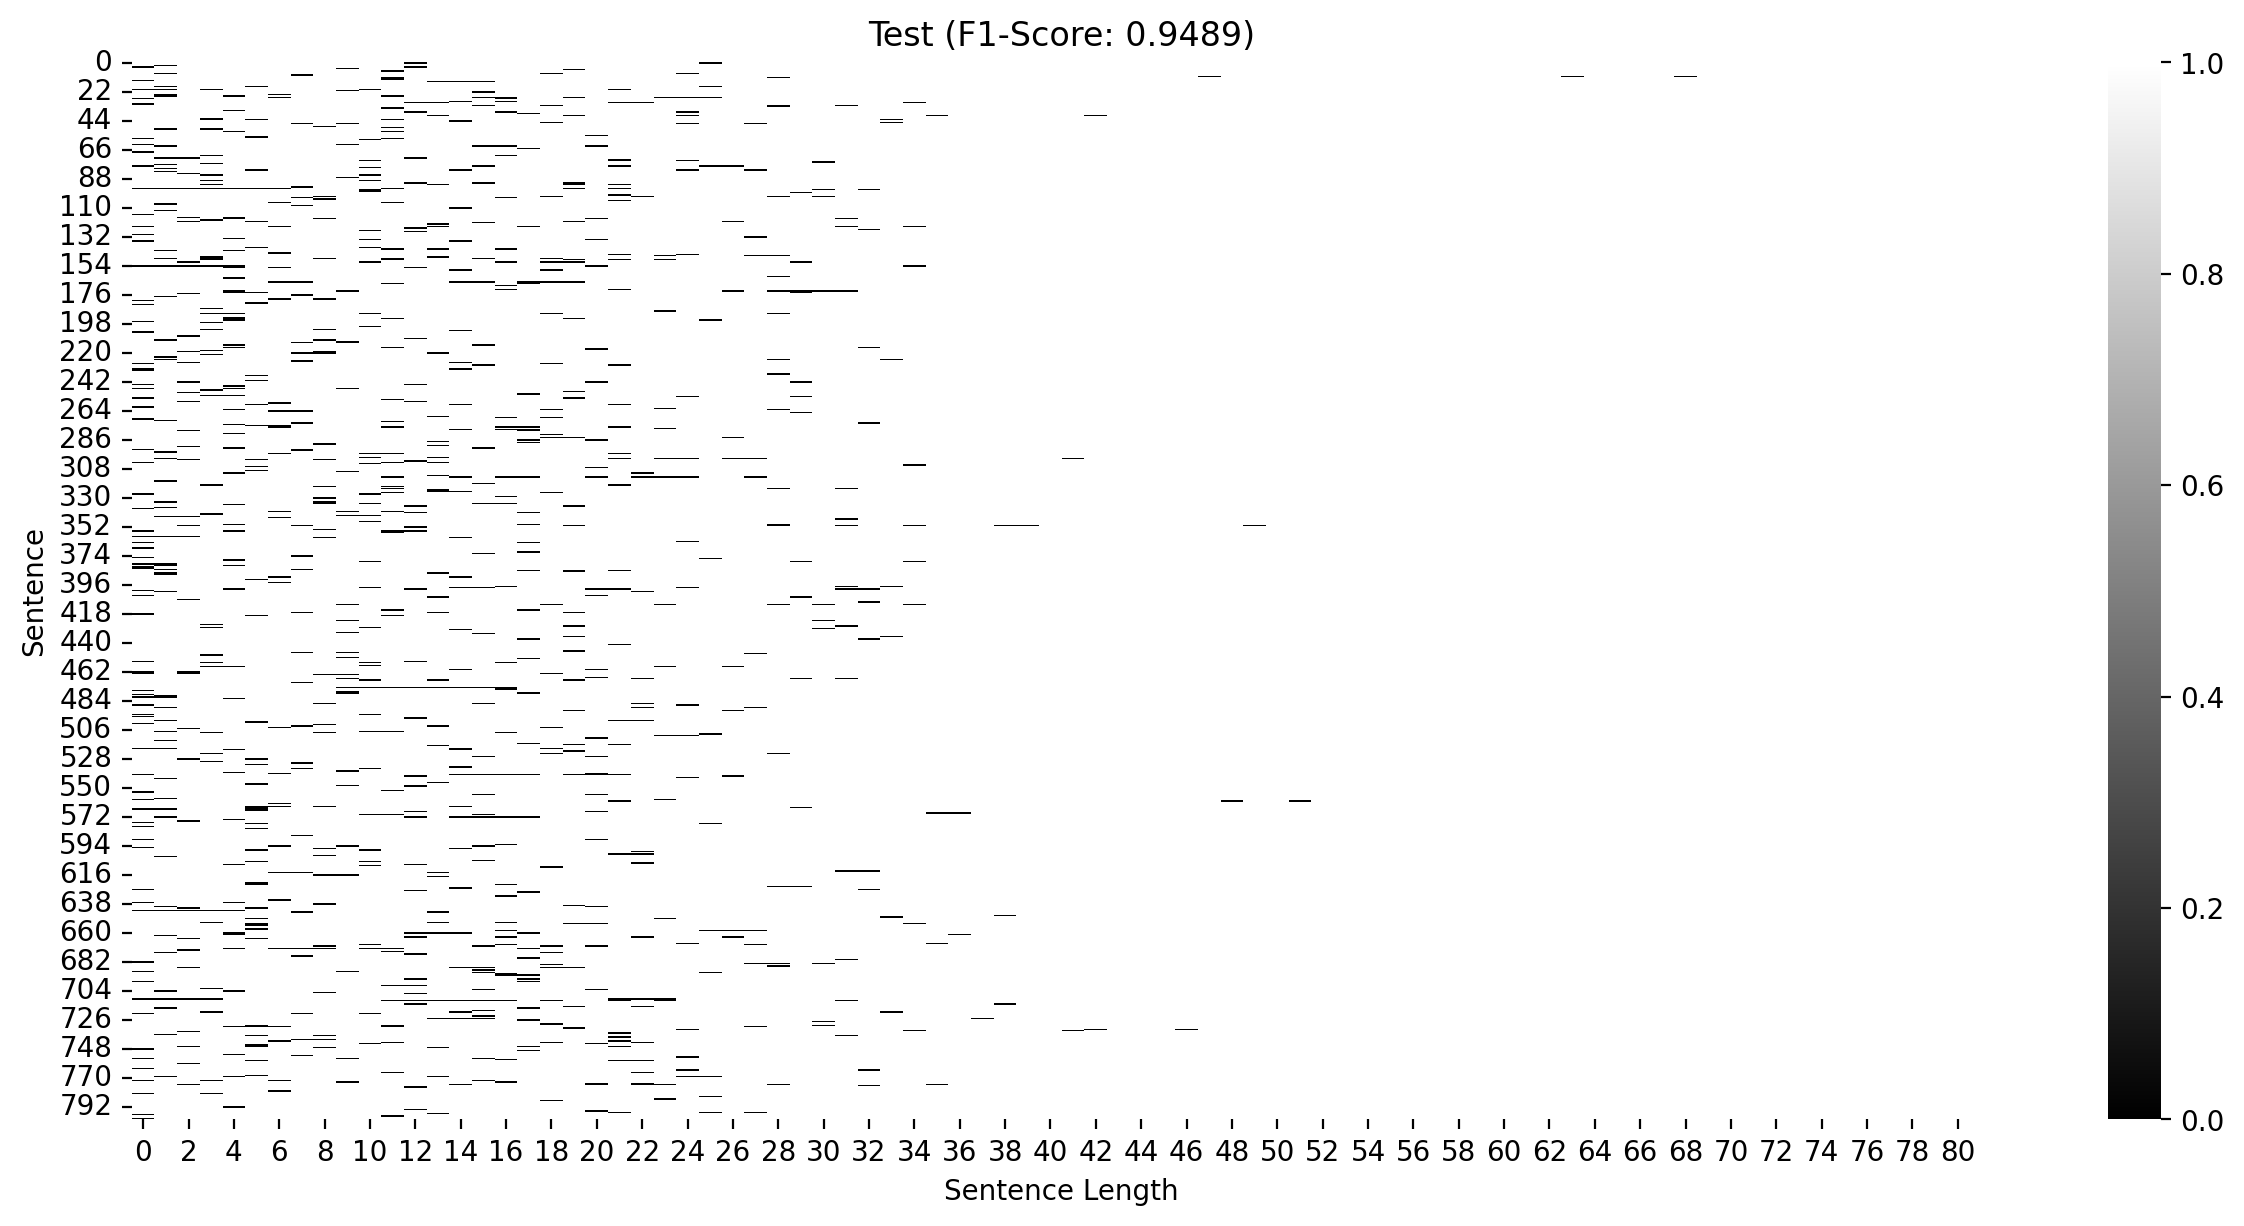

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


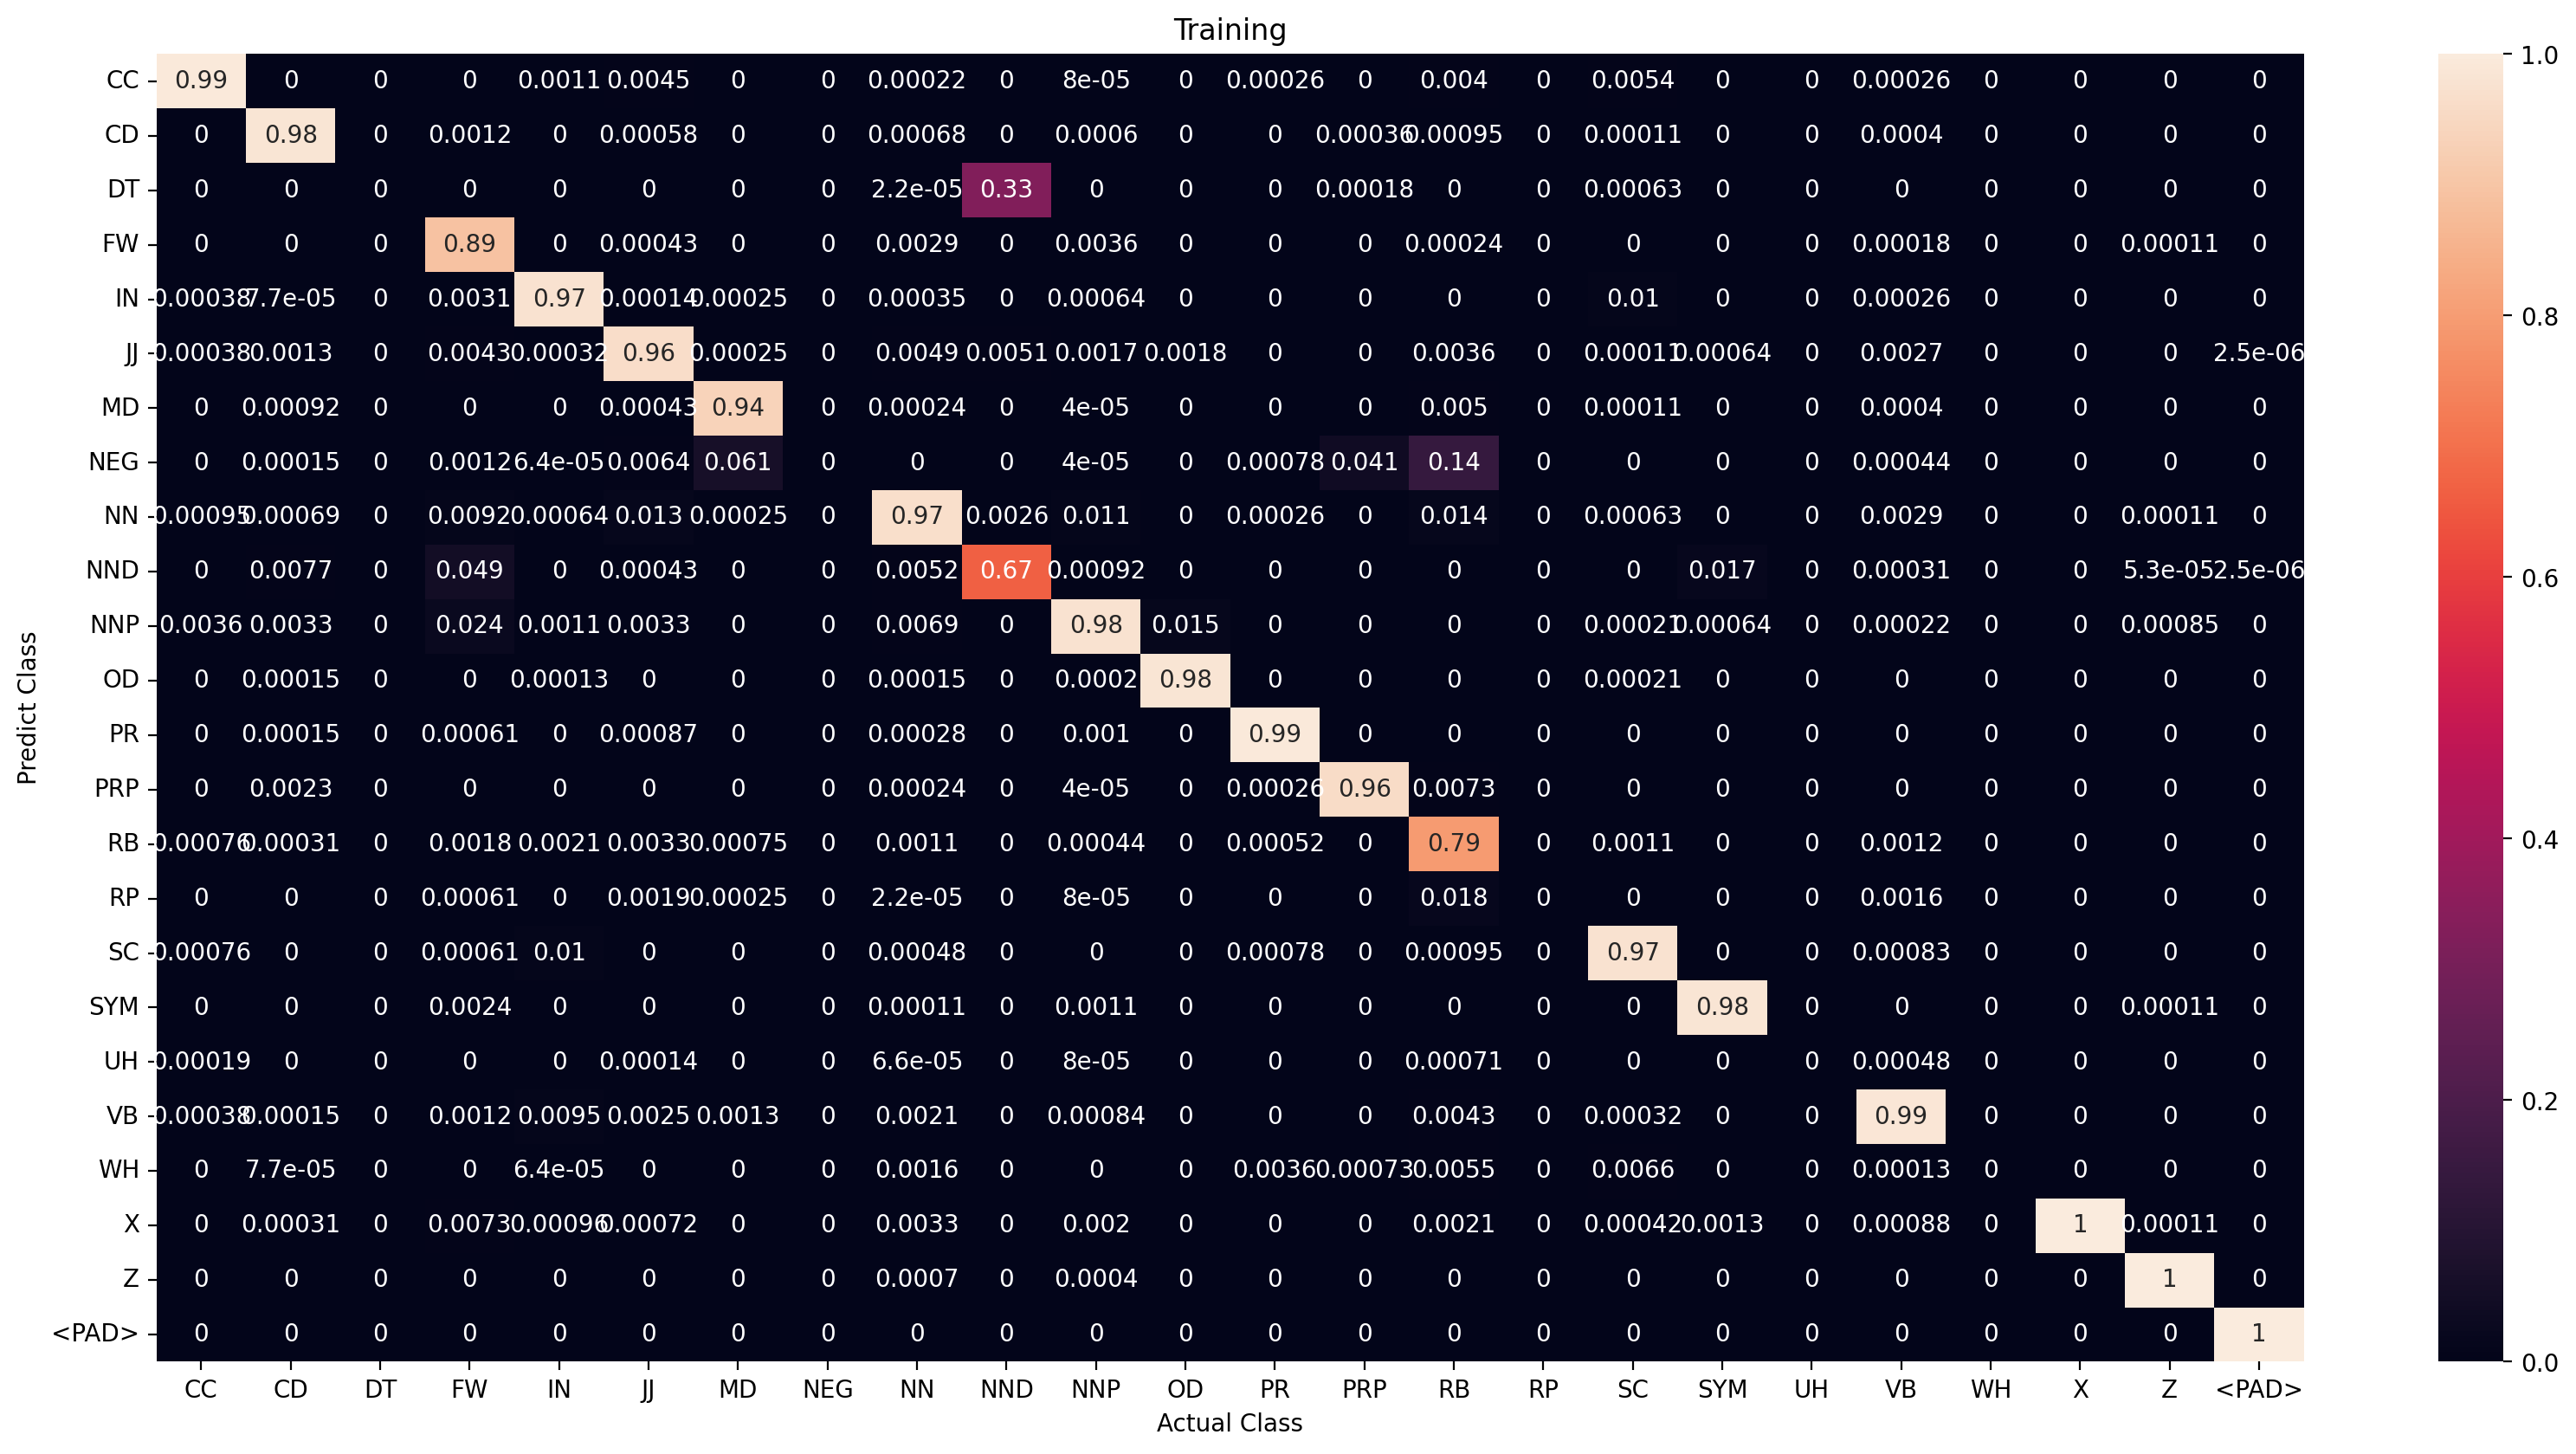

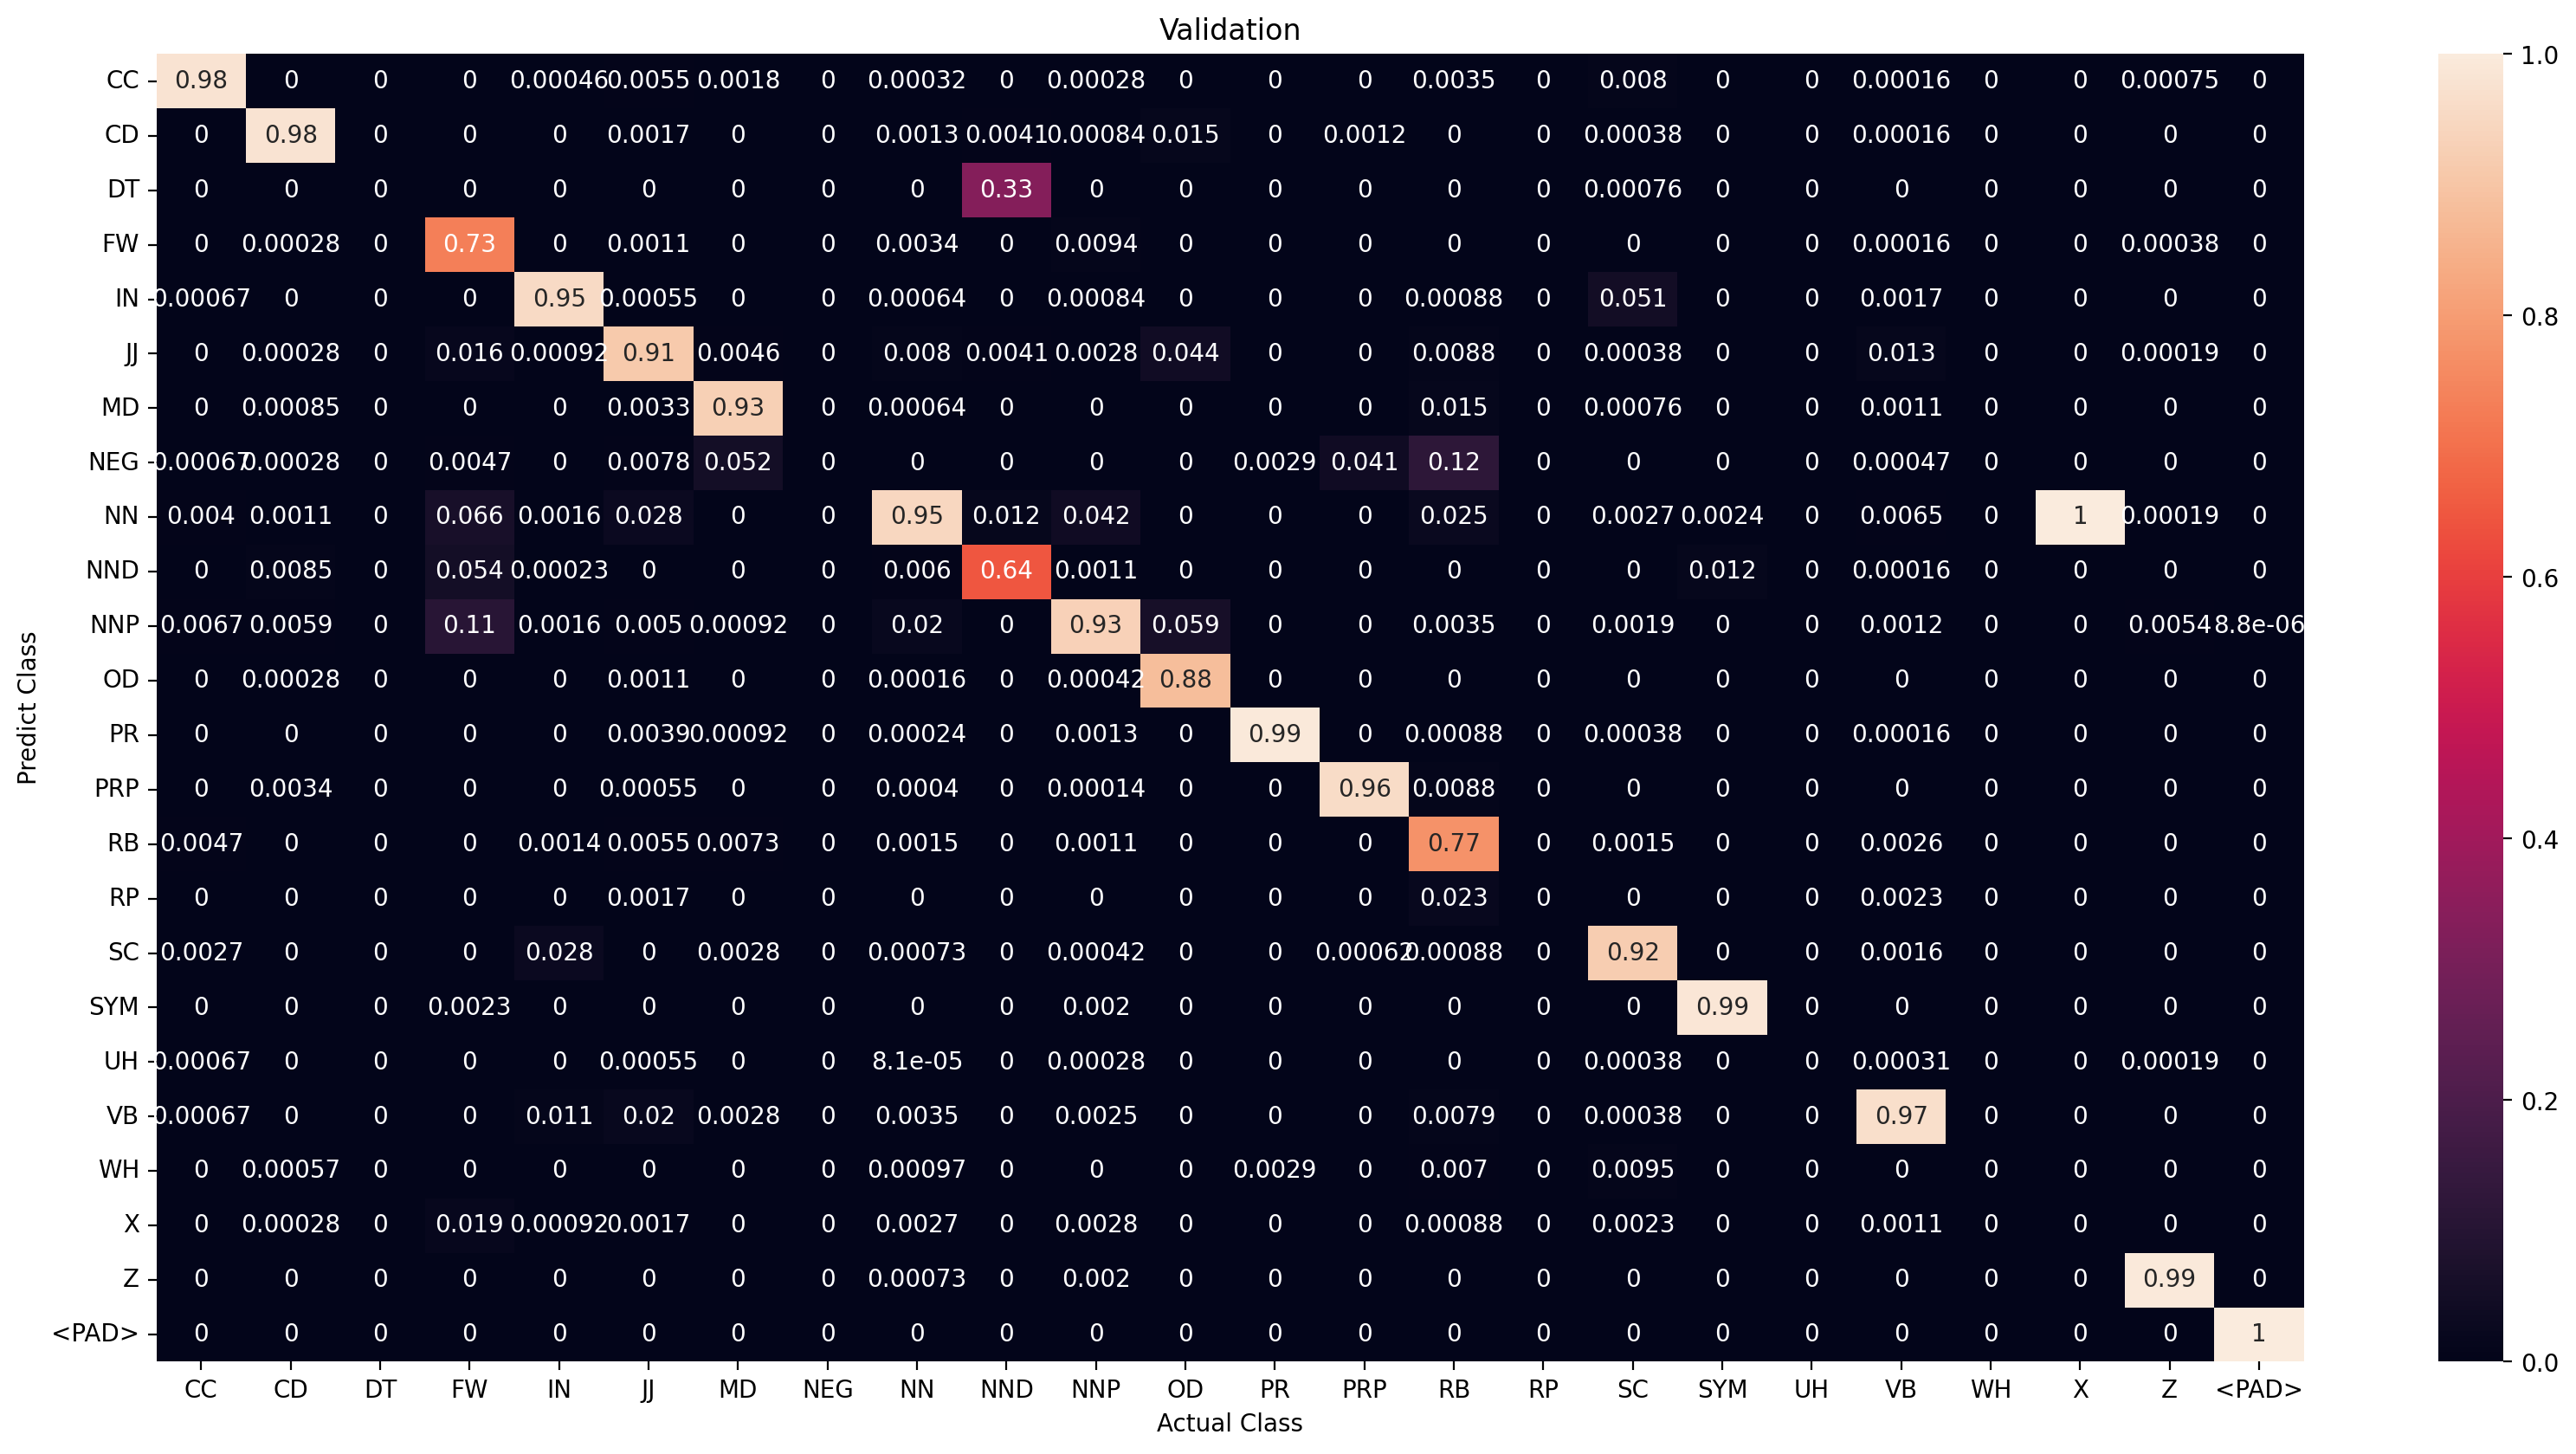

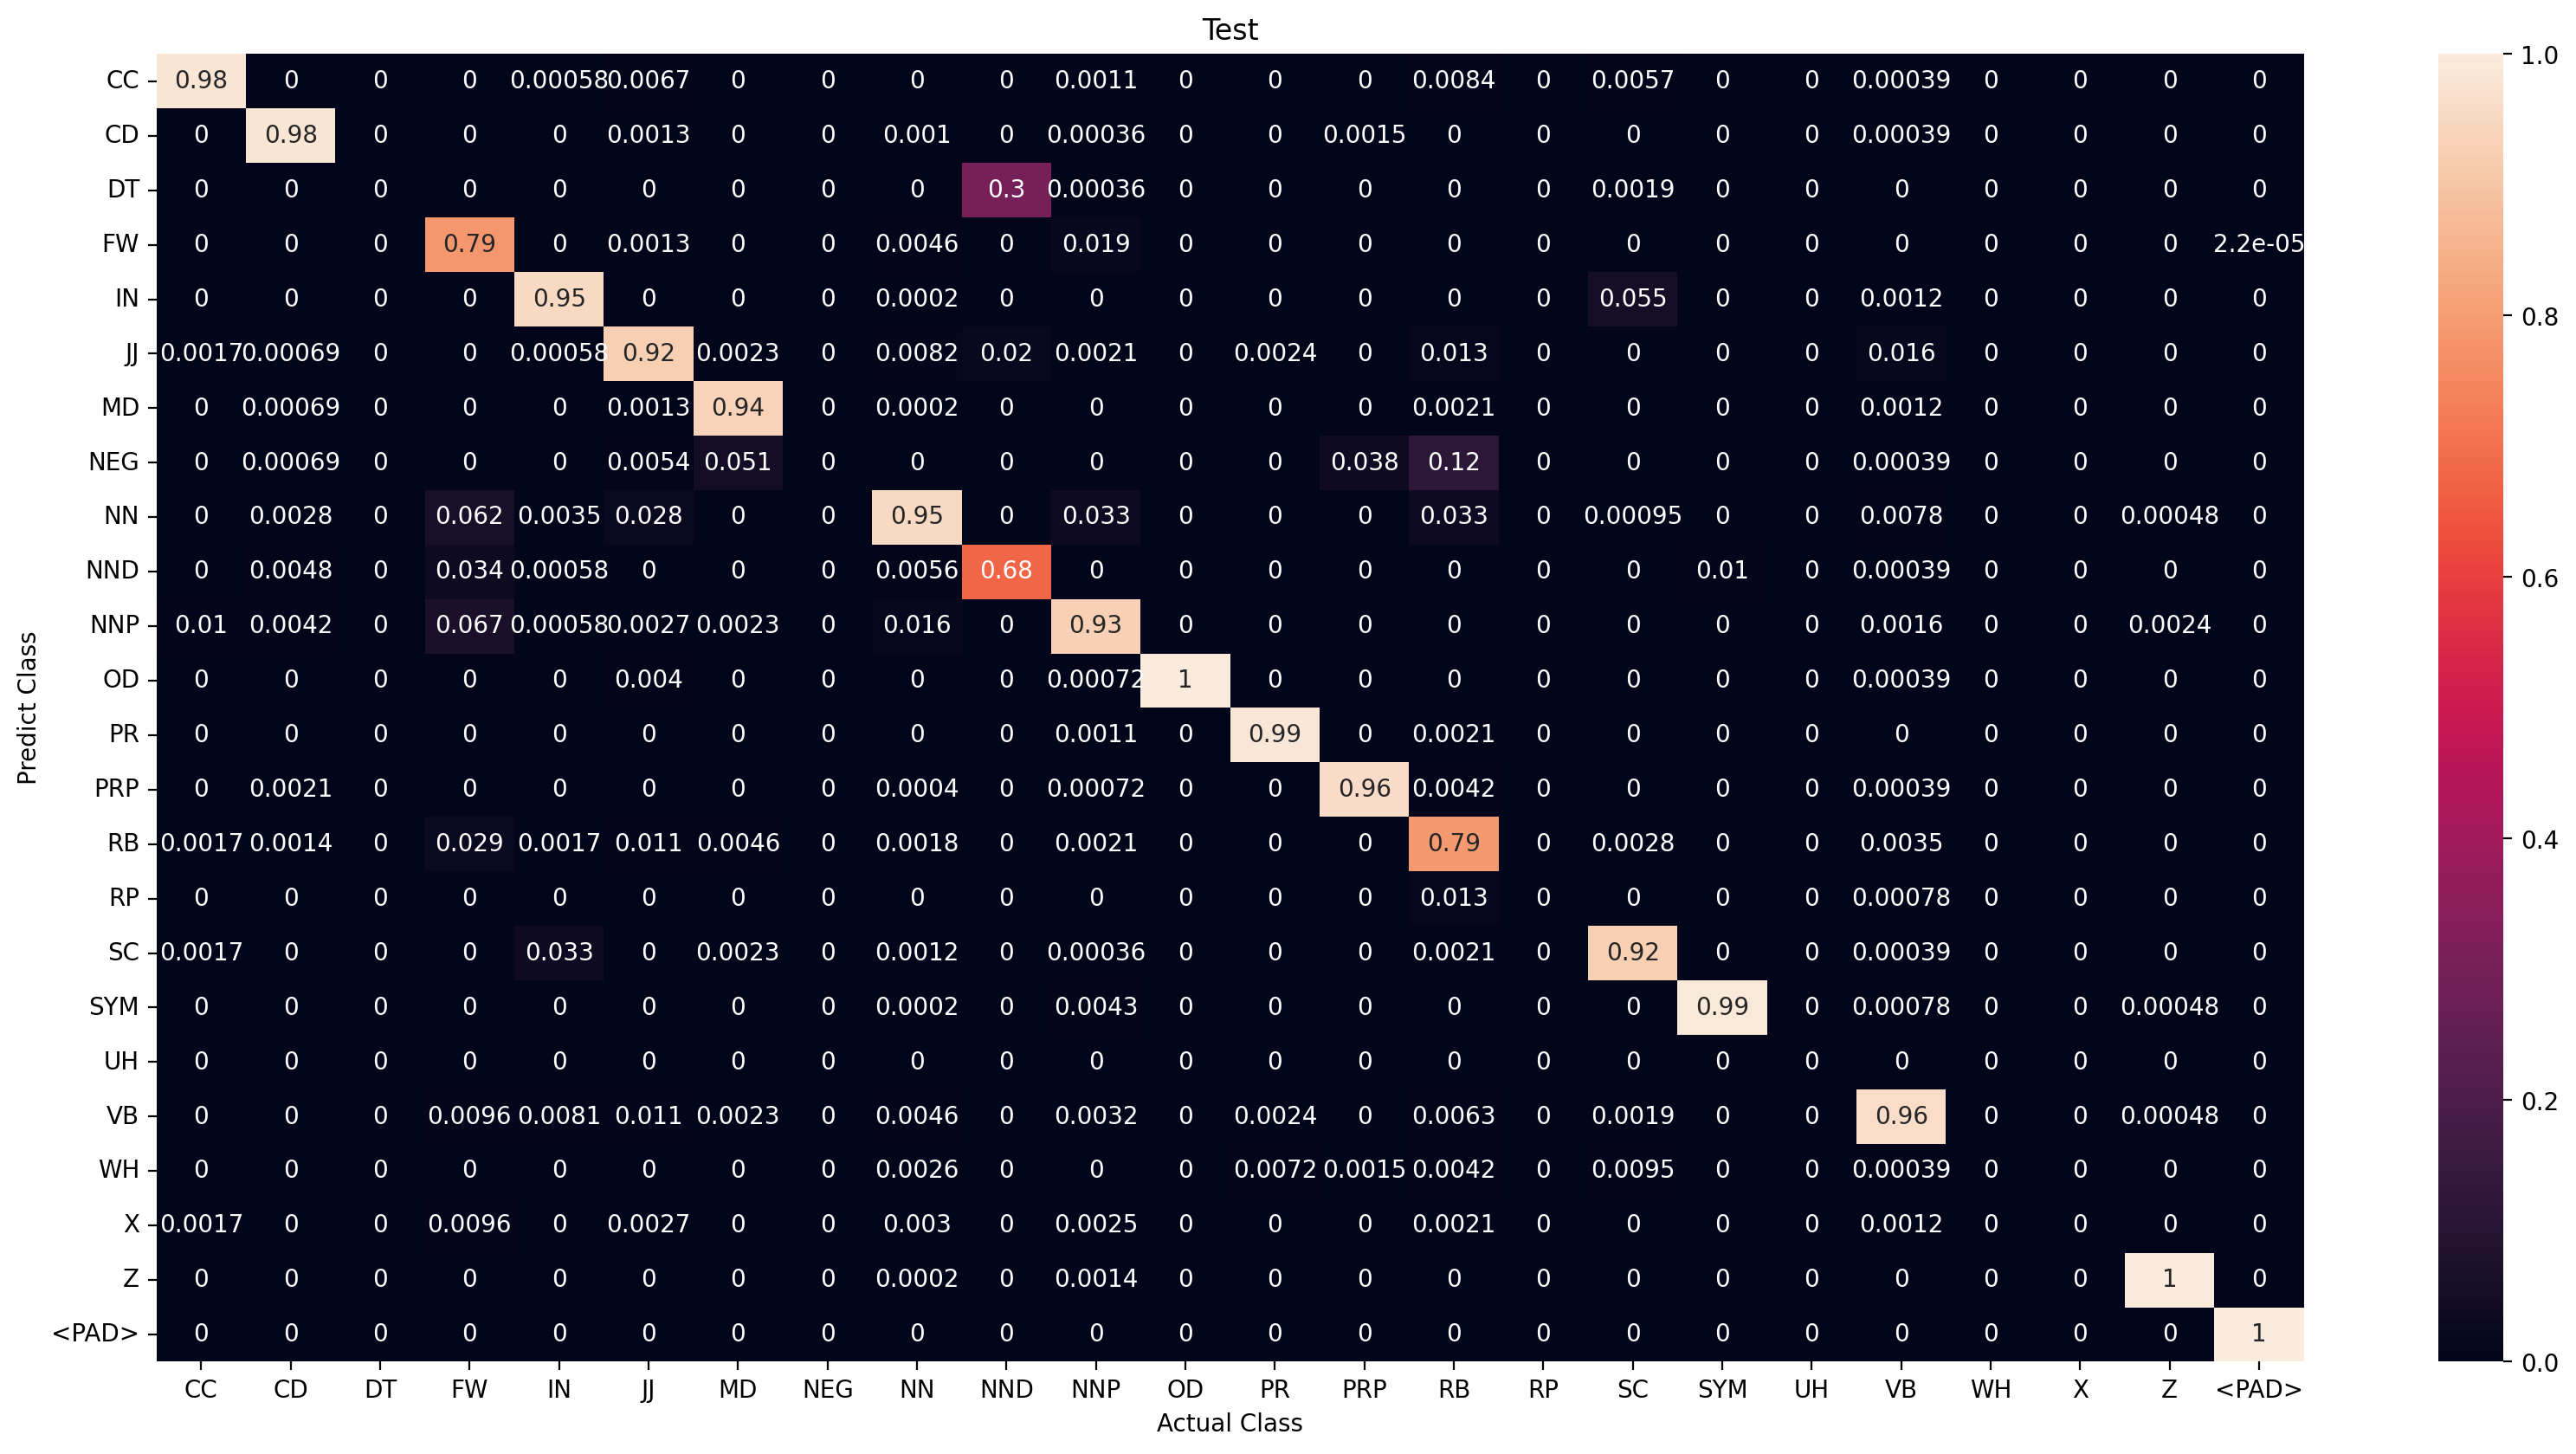

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5201       | CC    : 135      |
| CD    : 12904  | CD    : 12836      | CD    : 68       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1463       | FW    : 234      |
| IN    : 15290  | IN    : 15146      | IN    : 144      |
| JJ    : 7049   | JJ    : 6664       | JJ    : 385      |
| MD    : 3783   | MD    : 3725       | MD    : 58       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44245      | NN    : 524      |
| NND   : 998    | NND   : 519        | NND   : 479      |
| NNP   : 24884  | NNP   : 24396      | NNP   : 488      |
| OD    : 550    | OD    : 532        | OD    : 18       |
| PR    : 3878   | PR    : 3831       | PR    : 47       |
| PRP   : 5355   | PRP   : 5281       | PRP   : 74       |
| RB    : 3517   | RB    : 3347       | RB    : 170      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11245
Wrong prediction            : 689
Percentage correct oov pred : 94.22657952069716

Validation
Number OOV token            : 3261
Correct prediction          : 2924
Wrong prediction            : 337
Percentage correct oov pred : 89.6657467034652

Test
Number OOV token            : 1367
Correct prediction          : 1215
Wrong prediction            : 152
Percentage correct oov pred : 88.8807607900512



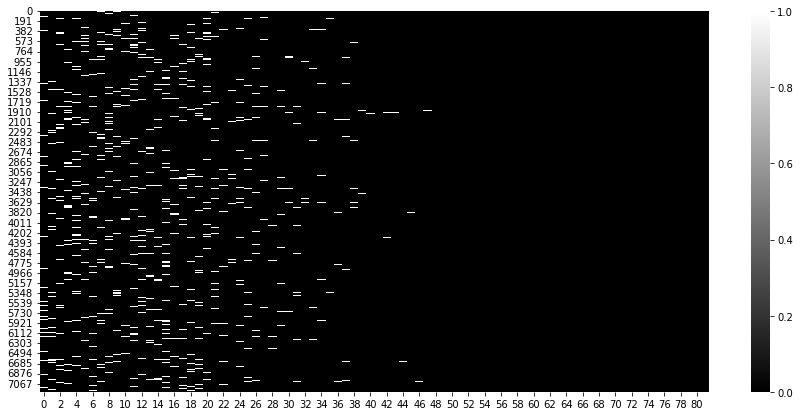

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

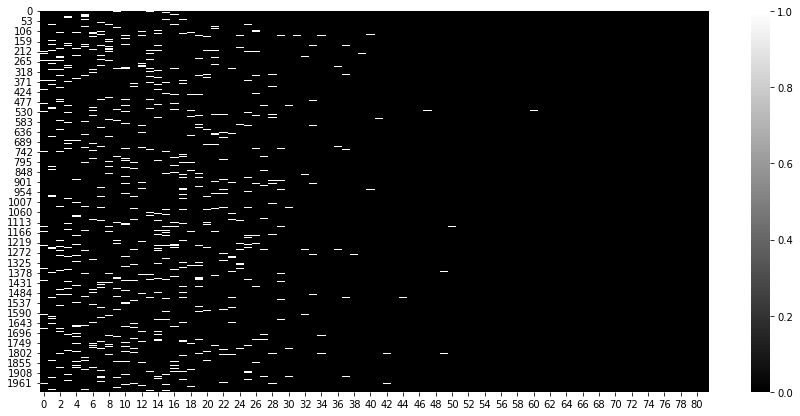

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

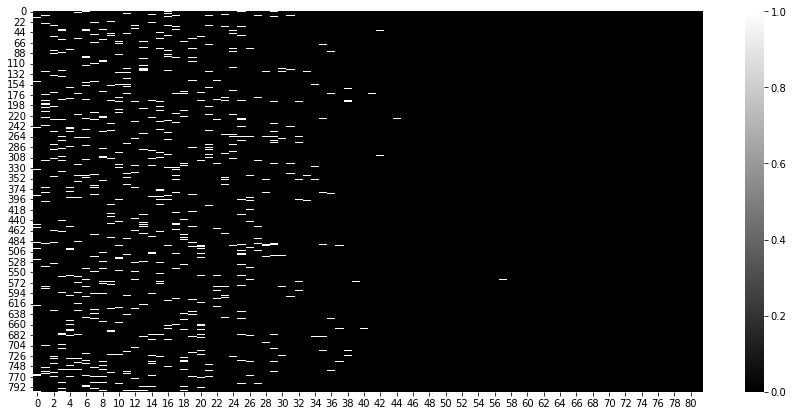

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);